In [28]:
# Importing Modules 
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MaxAbsScaler

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings('ignore')

In [29]:
# Function for plotting grids with matplotlib
def plot_grid(df, nrows, ncols):
    
    fix, axes = plt.subplots(nrows=nrows, ncols=ncols, dpi=120, figsize=(10,6))
    for i, ax in enumerate(axes.flatten()):
        data = df[df.columns[i]]
        ax.plot(data, linewidth=1)
        
        ax.set_title(df.columns[i])
        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')
        ax.spines['top'].set_alpha(0)
        ax.tick_params(labelsize=6)
        
    plt.tight_layout();

In [30]:
# Read CSVs
df_DJI = pd.read_csv('./DATA/INDICES/DJI_OHLCV.csv', parse_dates=['Date'], infer_datetime_format=True, index_col="Date" )

# Compute stdev
df_DJI['stdev'] = df_DJI['Close'].pct_change().rolling(window=5).std()

df_DJI.dropna(inplace=True)
print(df_DJI.shape)
df_DJI.head()

(3006, 6)


,Open,High,Low,Close,Volume,stdev
Date,,,,,,
2010-10-08,10948.50,11032.17,10929.28,11006.48,152279344,0.009458
2010-10-11,11006.93,11030.50,10977.90,11010.34,114830032,0.007813
2010-10-12,11010.79,11053.21,10913.84,11020.40,155152240,0.002588
2010-10-13,11022.82,11155.23,11022.07,11096.08,224916512,0.003599
2010-10-14,11096.99,11112.20,11023.54,11094.57,196166560,0.003194


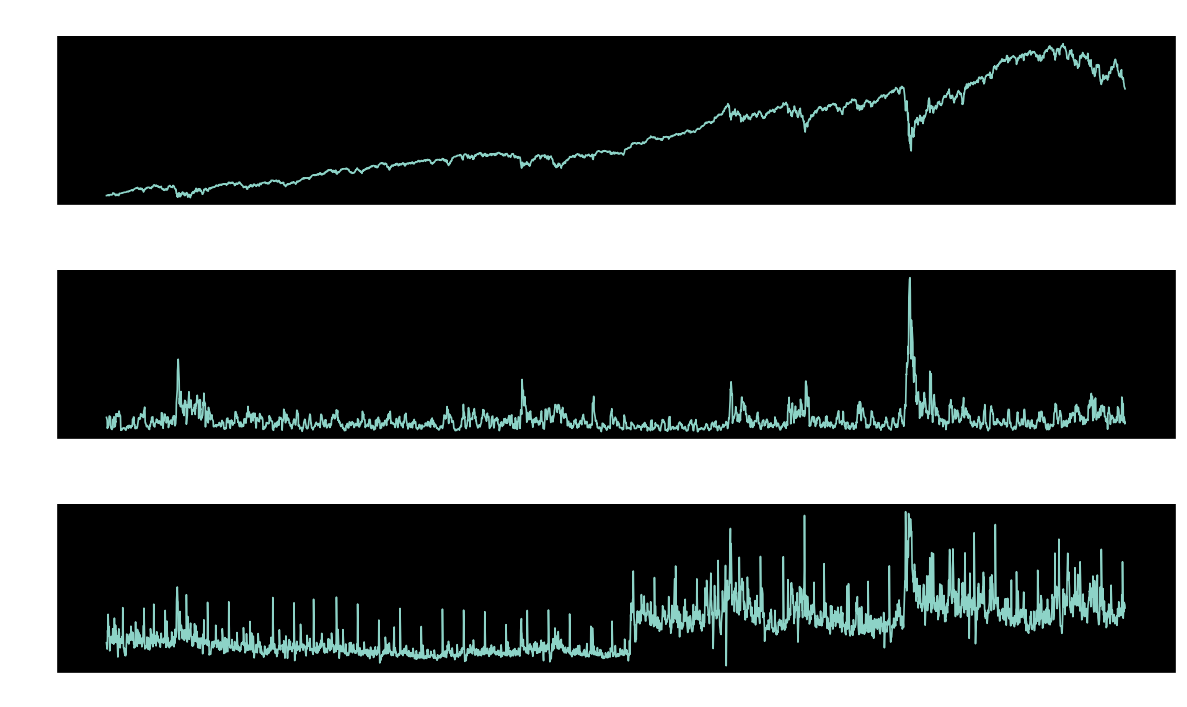

In [31]:
# Plot dataset
plot_grid(df_DJI[['Close', 'stdev', 'Volume']], 3, 1)

In [32]:
# Check stationarity
adfuller_res = adfuller(df_DJI['Close'][1:])

print(f'ADF Statistic (Close): {adfuller_res[0]}')
print(f'p-value: {adfuller_res[1]}')

adfuller_res = adfuller(df_DJI['Volume'][1:])

print(f'ADF Statistic (Volume): {adfuller_res[0]}')
print(f'p-value: {adfuller_res[1]}')

adfuller_res = adfuller(df_DJI['stdev'][1:])

print(f'ADF Statistic (stdev): {adfuller_res[0]}')
print(f'p-value: {adfuller_res[1]}')

# Close (and other candle data) is non-stationary
# Correct it by setting enforce_stationarity=True in model creation

ADF Statistic (Close): -0.9609399386015294
p-value: 0.767242748276715
ADF Statistic (Volume): -2.4277385494405563
p-value: 0.13405995443877028
ADF Statistic (stdev): -7.7789461702309355
p-value: 8.519180395746788e-12


In [33]:
# Scale the data with MaxAbsScaler
scaler = MaxAbsScaler()
scaler.fit(df_DJI)
df_DJI_scaled = scaler.transform(df_DJI)
df_DJI_scaled = pd.DataFrame(df_DJI_scaled, columns=df_DJI.columns).dropna()

# Number of days in test & train set
n_train = 2500
n_test = len(df_DJI) - n_train

# Split data
df_train = df_DJI_scaled.iloc[:n_train]
df_test = df_DJI_scaled.iloc[n_train:n_test+n_train]

# Create separate test set to preserve index for plotting predictions later
df_DJI_test = df_DJI.iloc[n_train:n_test+n_train]

print(f'Number of training days: {n_train}')
print(f'Number of testing days: {n_test}')

display(df_train.head(3))
display(df_test.head(3))

Number of training days: 2500
Number of testing days: 506


,Open,High,Low,Close,Volume,stdev
0,0.298141,0.298549,0.298321,0.299092,0.165040,0.097260
1,0.299732,0.298504,0.299648,0.299197,0.124453,0.080343
2,0.299837,0.299118,0.297899,0.299470,0.168154,0.026613


,Open,High,Low,Close,Volume,stdev
2500,0.727511,0.733232,0.724342,0.728687,0.486389,0.115920
2501,0.726923,0.737140,0.727028,0.738430,0.424554,0.150805
2502,0.745104,0.750220,0.746865,0.749574,0.439007,0.141172


In [41]:
# Split exogenous and endogenous variables
endog = df_train.drop(columns=['Volume'])
exog = df_train['Volume']

# Create VARMAX Model
model = VARMAX(
    endog,
    exog=exog,
    order=(1,1),
    # error_cov_type='diagonal',
    enforce_stationarity=True,
    filter_concentrated=True
)

# Fit model
model_fit = model.fit(disp=True)
model_fit.summary()

Dep. Variable:,"['Open', 'High', 'Low', 'Close', 'stdev']",No. Observations:,2500
Model:,"VARMAX(1,1)",Log Likelihood,46112.239
,+ intercept,AIC,-92072.478
Date:,"Wed, 28 Sep 2022",BIC,-91629.850
Time:,19:37:07,HQIC,-91911.783
Sample:,0,Scale,0.678
,- 2500,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"1800.87, 1.37, 0.21, 0.46, 4.71",Jarque-Bera (JB):,"29.03, 13605.76, 21496.21, 39147.81, 23596.95"
Prob(Q):,"0.00, 0.24, 0.65, 0.50, 0.03",Prob(JB):,"0.00, 0.00, 0.00, 0.00, 0.00"
Heteroskedasticity (H):,"0.90, 3.43, 4.58, 6.27, 1.98",Skew:,"-0.26, 1.69, -2.24, -1.26, 0.69"


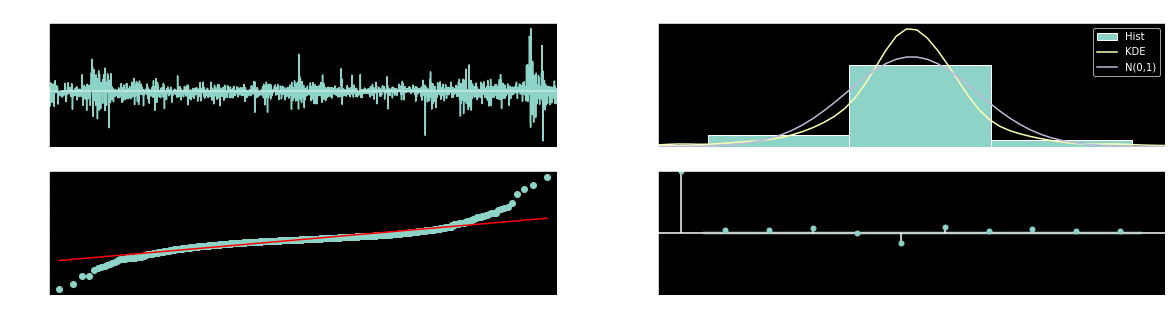

In [42]:
# Plot stdev diagnostics
model_fit.plot_diagnostics(4,figsize=(20,5));

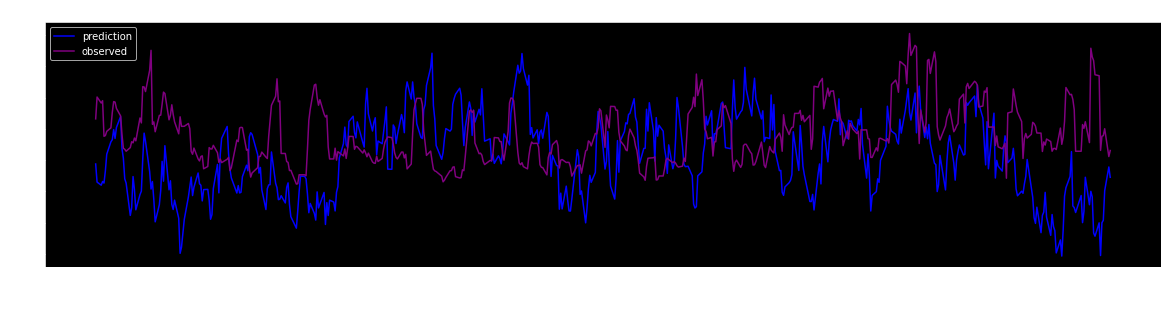

In [43]:
# Plot predicted vs observed volatility
pred = pd.DataFrame(index=df_DJI_test.index)
pred['prediction'] = model_fit.simulate(n_test).set_index(pred.index, drop=True)['stdev']
pred['observed'] = df_test.set_index(pred.index, drop=True)['stdev']
pred.plot(figsize=(20,5),title='predicted vs observed volatility',color=['blue','purple'])
plt.legend(loc=('upper left'));

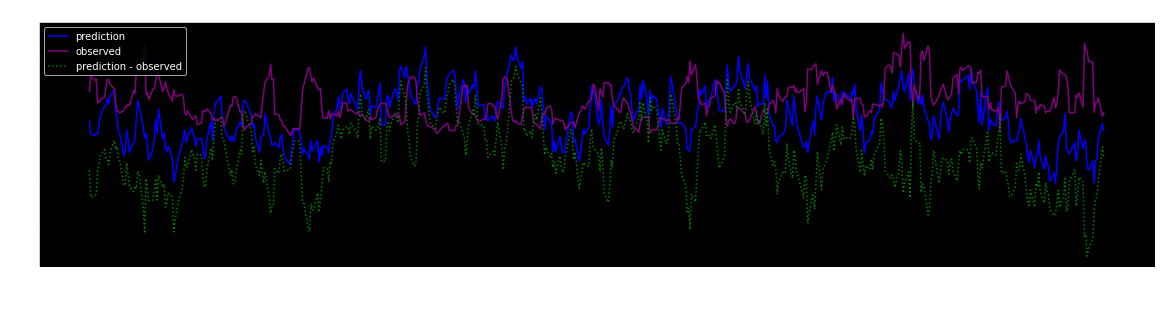

In [44]:
# Plot error
pred['prediction - observed'] = pred['prediction'] - pred['observed']
pred.plot(figsize=(20,5),title='volatility forecast error',color=['blue','purple','green'],style=['-','-',':'])
plt.legend(loc=('upper left'));

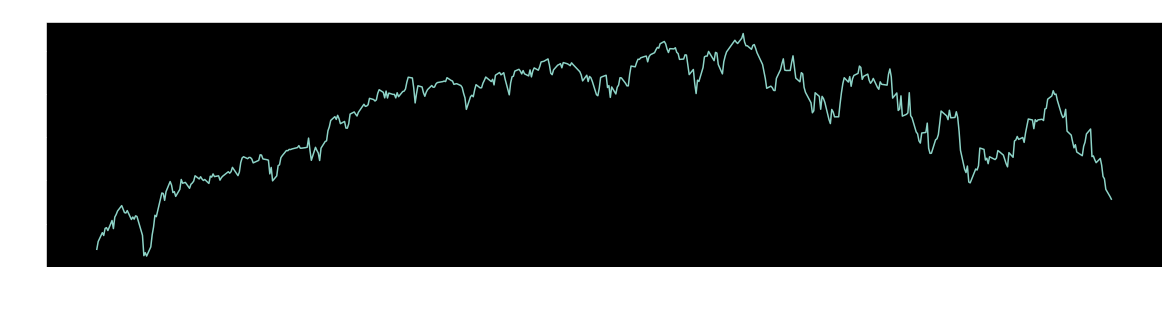

In [45]:
# Compare with Close data
df_DJI_test['Close'].plot(figsize=(20,5), title=('DJI Close'));